In [666]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.ensemble import GradientBoostingClassifier, StackingClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import RandomizedSearchCV

from xgboost import XGBClassifier

from catboost import CatBoostClassifier

from IPython.display import display

In [546]:
data_path = "data"
trainset = data_path + "/train.csv"
testset = data_path + "/test.csv"
originalset = data_path + "/original.csv"
submissionset = data_path + "/submissions.csv"

In [508]:
%matplotlib inline
sns.set()

In [509]:
trainframe = pd.concat([pd.read_csv(trainset), pd.read_csv(originalset).drop(columns=["RowNumber"])])
display(trainframe.describe())
display(trainframe.head(3))

,id,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,165034.0000,1.750360e+05,175036.000000,175035.000000,175036.000000,175036.000000,175036.000000,175035.000000,175035.000000,175036.000000,175036.000000
mean,82516.5000,1.569194e+07,656.117273,38.171393,5.019904,56678.824183,1.553069,0.751187,0.498752,111861.027293,0.211151
std,47641.3565,7.142866e+04,81.151830,8.969523,2.811125,62982.466070,0.549210,0.432327,0.500000,50815.418008,0.408126
min,0.0000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,41258.2500,1.563288e+07,597.000000,32.000000,3.000000,0.000000,1.000000,1.000000,0.000000,73181.390000,0.000000
50%,82516.5000,1.569017e+07,659.000000,37.000000,5.000000,0.000000,2.000000,1.000000,0.000000,116969.730000,0.000000
75%,123774.7500,1.575666e+07,710.000000,42.000000,7.000000,120729.770000,2.000000,1.000000,1.000000,154767.340000,0.000000
max,165033.0000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.000000


,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0.0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.0,2,1.0,0.0,181449.97,0
1,1.0,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.0,2,1.0,1.0,49503.50,0
2,2.0,15694510,Hsueh,678,France,Male,40.0,10,0.0,2,1.0,0.0,184866.69,0


In [510]:
drop_columns = ["Surname", "id", "CustomerId", "Geography", "Gender"]

In [511]:
def str2int(df: pd.DataFrame, *columns) -> pd.DataFrame:
    """Convert string columns to integers format"""
    for col in columns:
        unique = df[col].unique()
        dict_ = dict()
        for value, key in enumerate(unique):
            dict_[key] = value
        df[col] = df[col].map(lambda value: dict_[value])
    return df

In [512]:
def create_columns(df: pd.DataFrame) -> pd.DataFrame:
    """add new columns"""
    df["IsActiveMemberWithCrCard"] = df["IsActiveMember"] * df["HasCrCard"]
    df["PropotionAgeTenure"] = df["Tenure"] / df["Age"]
    df["PropotionBalanceSalary"] = df["EstimatedSalary"] / (df["Balance"] + 1.0)
    df["NumOfProductsWithoutCrCard"] = df["NumOfProducts"] - df["HasCrCard"]
    df["Germany"] = df["Geography"] == "Germany"
    df["France"] = df["Geography"] == "France"
    df["Spain"] = df["Geography"] == "Spain"
    df["Male"] = df["Gender"] == "Male"
    df["Female"] = df["Gender"] == "Female"
    df["GermanyFemale"] = (df["Geography"] == "Germany") & (df["Gender"] == "Female")
    df["GermanyMale"] = (df["Geography"] == "Germany") & (df["Gender"] == "Male")
    df["FranceMale"] = (df["Geography"] == "France") & (df["Gender"] == "Male")
    df["FranceFemale"] = (df["Geography"] == "France") & (df["Gender"] == "Female")
    df["SpainFemale"] = (df["Geography"] == "Spain") & (df["Gender"] == "Female")
    df["SpainMale"] = (df["Geography"] == "Spain") & (df["Gender"] == "Male")
    df["AgeBalanceNumOfProducts"] = df["Age"] * df["Balance"] / df["NumOfProducts"]
    df["ProductsPerTenure"] = np.where(df["Tenure"] != 0, df["NumOfProducts"] / df["Tenure"], df["NumOfProducts"])

    age_bins = [0, 18, 30, 40, 50, 60, 100]
    df["AgeGroup"] = pd.cut(df["Age"], bins=age_bins, labels=False, right=False)

    balance_bins = [-np.inf, 0, 10000, 50000, 100000, np.inf]
    df["BalanceCategory"] = pd.cut(df["Balance"], bins=balance_bins, labels=False, right=False)

    credit_bins = [0, 500, 600, 700, 800, 850]
    df["CreditScoreCategory"] = pd.cut(df["CreditScore"], bins=credit_bins, labels=False, right=False)

    tenure_bins = [0, 2, 5, 10, np.inf]
    df["TenureGroup"] = pd.cut(df["Tenure"], bins=tenure_bins, labels=False, right=False)
    
    df.fillna(0.0, inplace=True)
    
    return df

In [513]:
# add new columns
trainframe = create_columns(trainframe)

In [514]:
trainframe = trainframe.drop(columns=drop_columns)

In [515]:
display(trainframe.head(7))

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,IsActiveMemberWithCrCard,...,FranceMale,FranceFemale,SpainFemale,SpainMale,AgeBalanceNumOfProducts,ProductsPerTenure,AgeGroup,BalanceCategory,CreditScoreCategory,TenureGroup
0,668,33.0,3,0.00,2,1.0,0.0,181449.97,0,0.0,...,True,False,False,False,0.00,0.666667,2.0,1,2.0,1
1,627,33.0,1,0.00,2,1.0,1.0,49503.50,0,1.0,...,True,False,False,False,0.00,2.000000,2.0,1,2.0,0
2,678,40.0,10,0.00,2,1.0,0.0,184866.69,0,0.0,...,True,False,False,False,0.00,0.200000,3.0,1,2.0,3
3,581,34.0,2,148882.54,1,1.0,1.0,84560.88,0,1.0,...,True,False,False,False,5062006.36,0.500000,2.0,4,1.0,1
4,716,33.0,5,0.00,2,1.0,1.0,15068.83,0,1.0,...,False,False,False,True,0.00,0.400000,2.0,1,3.0,2
5,588,36.0,4,131778.58,1,1.0,0.0,136024.31,1,0.0,...,False,False,False,False,4744028.88,0.250000,2.0,4,1.0,1
6,593,30.0,8,144772.69,1,1.0,0.0,29792.11,0,0.0,...,False,True,False,False,4343180.70,0.125000,2.0,4,1.0,2


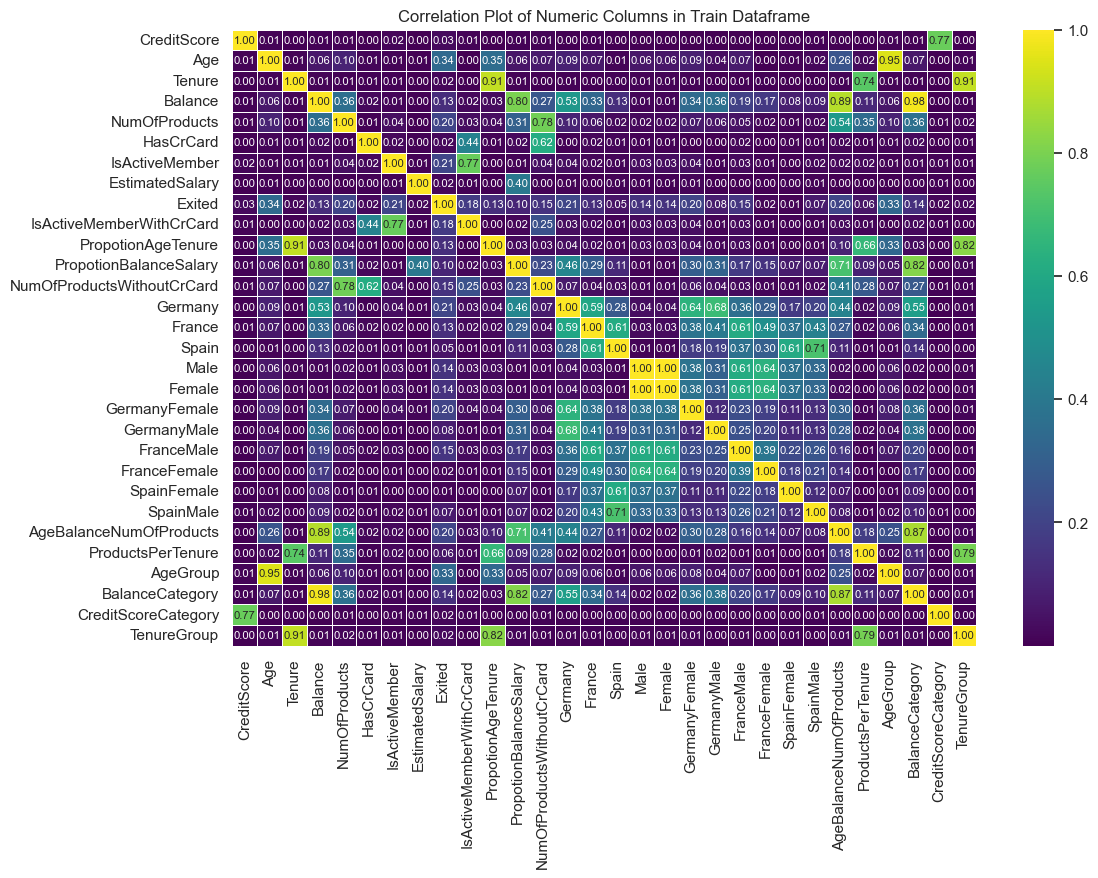

In [516]:
columns = trainframe.select_dtypes(include=["number", "bool"])

corr_matrix = columns.corr().map(abs)

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="viridis", fmt=".2f", linewidths=0.5, annot_kws={"size": 8})
plt.title("Correlation Plot of Numeric Columns in Train Dataframe")
plt.show()

In [517]:
err_corr_features = ["Age", "Tenure", "Balance", "CreditScoreCategory", "HasCrCard", "EstimatedSalary", "CreditScore"]
trainframe = trainframe.drop(columns=err_corr_features)

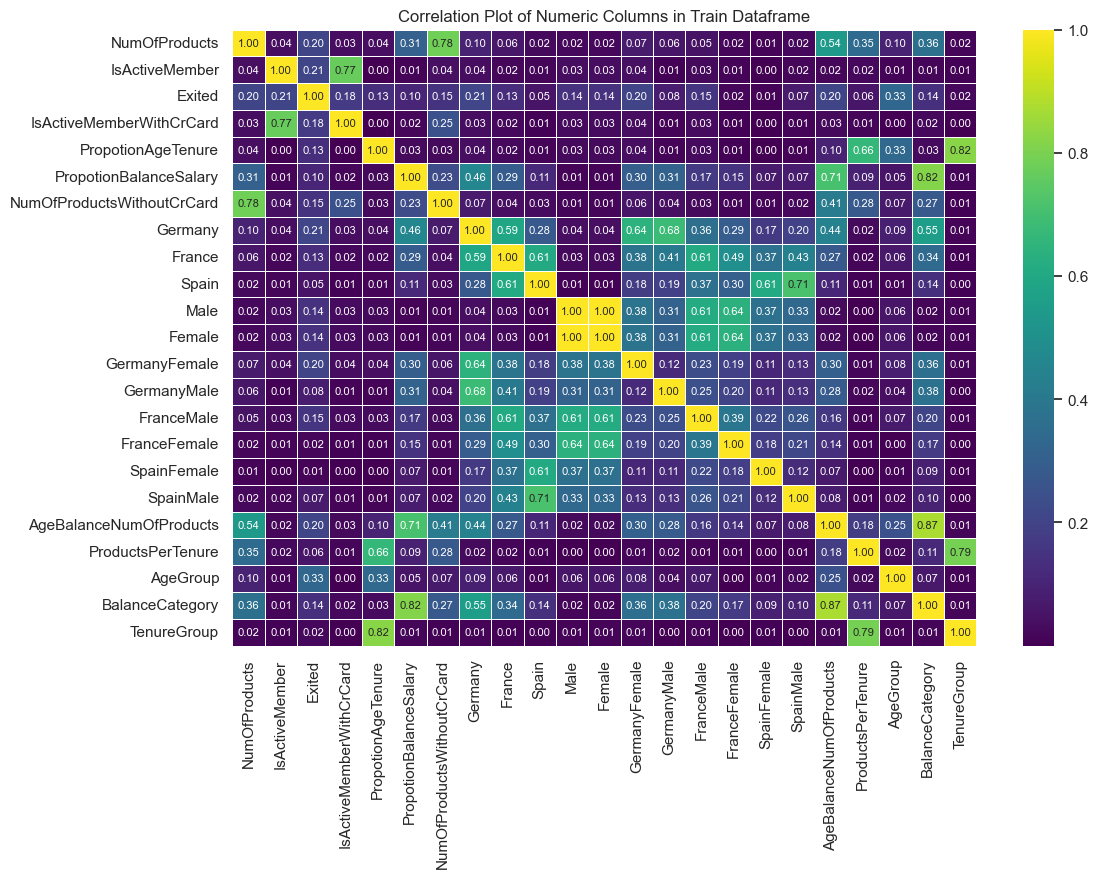

In [518]:
columns = trainframe.select_dtypes(include=["number", "bool"])

corr_matrix = columns.corr().map(abs)

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="viridis", fmt=".2f", linewidths=0.5, annot_kws={"size": 8})
plt.title("Correlation Plot of Numeric Columns in Train Dataframe")
plt.show()

In [519]:
train_X, train_y = trainframe.loc[:, ~trainframe.columns.isin(["Exited"])].to_numpy(dtype=np.float64), trainframe["Exited"].to_numpy(dtype=np.float64)
display(train_X.shape, train_y.shape)

(175036, 22)

(175036,)

In [520]:
testframe = pd.read_csv(testset)

In [521]:
testframe = create_columns(testframe)
testframe = testframe.drop(columns=drop_columns + err_corr_features)

In [522]:
valid_X = testframe.to_numpy(dtype=np.float64)
display(valid_X.shape)

(110023, 22)

In [524]:
scaler = StandardScaler()
scaler.fit(trainframe.drop(["Exited"], axis=1))

X_train = scaler.transform(trainframe.drop(["Exited"], axis=1))
y_train = trainframe["Exited"].to_numpy(dtype=np.float64)

X_valid = scaler.transform(testframe)

In [ ]:
seed = 39

final_model = MLPClassifier(
    hidden_layer_sizes=(64, 64),
    activation="tanh",
    solver="lbfgs",
    batch_size=64
)

In [ ]:
forest = RandomForestClassifier(random_state=seed)
rfr_parameters = {
    "n_estimators": range(50, 1000, 25),
    "max_depth": range(2, 30, 2),
    "min_samples_leaf": range(1, 101, 10),
    "min_samples_split": range(2, 101, 10)
}
random_search = RandomizedSearchCV(estimator=forest, param_distributions=rfr_parameters, 
                                   n_iter=20, n_jobs=-1, cv=5, verbose=4)
random_search.fit(train_X, train_y)
print(random_search.best_params_)
rfr_parameters = random_search.best_params_
# {"n_estimators": 800, "min_samples_split": 12, "min_samples_leaf": 11, "max_depth": 28}

In [ ]:
cat = CatBoostClassifier(random_state=seed)

cat_parameters = {
    "iterations": range(25, 1001, 25),
    "depth": range(2, 17),
    "learning_rate": [0.1, 0.05, 0.01, 0.005, 0.001]
}

random_search = RandomizedSearchCV(estimator=cat, param_distributions=cat_parameters, 
                                   n_iter=20, n_jobs=-1, cv=5, verbose=4)
random_search.fit(train_X, train_y)
print(random_search.best_params_)
cat_parameters = random_search.best_params_
# {"learning_rate": 0.1, "iterations": 400, "depth": 7}

In [ ]:
xgb = XGBClassifier(random_state=seed)

xgb_parameters = {
    "n_estimators": range(5, 1001, 10),
    "max_depth": range(2, 100, 4),
    "learning_rate": [0.1, 0.05, 0.01, 0.005, 0.001]
}

random_search = RandomizedSearchCV(estimator=xgb, param_distributions=xgb_parameters, 
                                   n_iter=15, n_jobs=-1, cv=5, verbose=4)
random_search.fit(train_X, train_y)
print(random_search.best_params_)
xgb_parameters = random_search.best_params_
# {"n_estimators": 725, "max_depth": 10, "learning_rate": 0.005}

In [668]:
grb = GradientBoostingClassifier(random_state=seed)

grb_parameters = {
    "n_estimators": range(5, 1001, 10),
    "max_depth": range(2, 100, 4),
    "learning_rate": [0.1, 0.05, 0.01, 0.005, 0.001]
}

random_search = RandomizedSearchCV(estimator=grb, param_distributions=grb_parameters, 
                                   n_iter=15, n_jobs=-1, cv=5, verbose=4)
random_search.fit(train_X, train_y)
print(random_search.best_params_)
grb_parameters = random_search.best_params_
# {"learning_rate": 0.1, "max_depth": 47, "n_estimators": 785}

In [673]:
models = [
    ("GRB", GradientBoostingClassifier(random_state=seed, **grb_parameters)),
    ("XGB", XGBClassifier(random_state=seed, **xgb_parameters)),
    ("CAT", CatBoostClassifier(random_state=seed, **cat_parameters)),
    ("RFR", RandomForestClassifier(random_state=seed, **rfr_parameters))
]

In [672]:
stacking_model = StackingClassifier(
    estimators=models,
    final_estimator=final_model,
    n_jobs=-1
)
stacking_model.fit(train_X, train_y)

InvalidParameterError: The 'learning_rate' parameter of GradientBoostingClassifier must be a float in the range [0.0, inf). Got [0.1, 0.05, 0.01, 0.005, 0.001] instead.

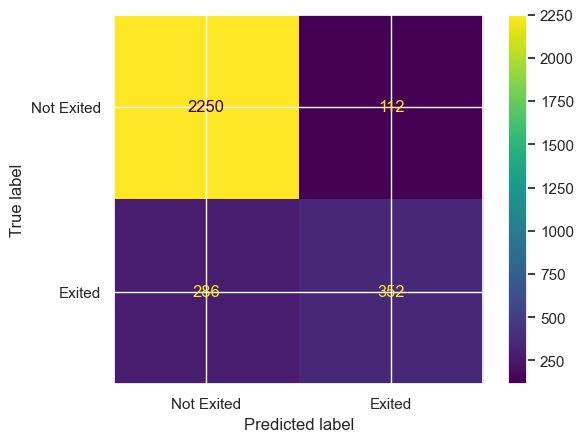

In [654]:
test_df = pd.read_csv(originalset).sample(frac=1).iloc[:3000]
test_df = create_columns(test_df)
drop_columns = ["Surname", "CustomerId", "Geography", "Gender", "RowNumber"]
test_df = test_df.drop(columns=err_corr_features + drop_columns)
X_test = test_df.loc[:, ~test_df.columns.isin(["Exited"])].to_numpy(dtype=np.float64)
y_test = test_df["Exited"].to_numpy(dtype=np.float64).reshape(-1, 1)

y_raw = stacking_model.predict(X_test).reshape(-1, 1)
y_true = y_test
y_pred = y_raw
matrix = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(matrix, 
                              display_labels=["Not Exited", "Exited"]
                             )
disp.plot()
display(f"Accuracy score: {accuracy_score(y_true, y_pred):.4f}")

In [543]:
submission_frame = pd.DataFrame()
submission_frame["id"] = range(165034, 275057)
submission_frame["Exited"] = stacking_model.predict(valid_X)
submission_frame.to_csv(submissionset, index=False)